# Supervised Learning

In this notebook, we are going to attempt different tree-based supervised learning models. They are:
- Decision Tree
- Random Forest
- CatBoost
- XGBoost
- LGMB

**Things to look into:**
- Why is the model so perfect?
- Is there something we are missing?
**Things to do:**
- edit the scoring metric to include recall and f1 (note: need to adjust it since our classification is multiclass)

# Load in the Dataset + Packages

In [41]:
# pip install graphviz
import sklearn
import graphviz 
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [42]:
#dataset
# df = pd.read_excel("df_full_clean.xlsx", usecols = "A:BB")
df = pd.read_excel(
    "../../data/processed/smote.xlsx", usecols="A:BA")


#imputation of NRI score with mean value
df['NRI score'] = df['NRI score'].replace(0, np.NaN)
df['NRI score'] = df['NRI score'].replace(np.NaN, df['NRI score'].mean())

In [43]:
df['NRI score'].mean()

77.85181533974607

In [44]:
df['NRI score'].unique()

array([77.85001289, 76.47961345, 81.0898203 , 49.7445967 , 72.25504781,
       40.92879163, 74.96251911, 78.94535536, 74.79074367, 82.06163752,
       80.01442087, 73.78914787, 76.59818693, 69.942859  , 77.24993597,
       76.58416771, 79.04332849, 76.62530199, 77.83817367, 77.588241  ,
       77.09374366, 78.71390676, 76.94896008, 76.89348655, 79.75262894,
       77.35887811, 76.75315358, 77.45234348, 77.11060515, 80.71599687,
       76.90927973, 77.74246448, 77.37730753, 80.09257354, 76.7838171 ,
       79.64092872, 76.72198351, 77.524824  , 77.76996464, 76.6739419 ,
       77.76159626, 79.47841328, 79.67321985, 77.57594077, 77.47867463,
       80.77442358, 76.84378847, 77.78457144, 76.70415405, 77.22144784,
       78.56509762, 78.47608348, 77.36137967, 77.1229458 , 79.81577545,
       76.76759618, 76.50167338, 80.9397677 , 76.9150306 , 76.64922443,
       79.75372224, 76.9570211 , 77.6727851 , 77.66679296, 77.78158096,
       77.61495824, 77.69023918, 77.32279653, 77.84891721, 77.31

In [45]:
df['Risk_Label'] = df['Risk_Label'].astype('category')
df['Risk_Label']

0          Low
1          Low
2       Medium
3          Low
4          Low
         ...  
1978       Low
1979       Low
1980       Low
1981       Low
1982       Low
Name: Risk_Label, Length: 1983, dtype: category
Categories (3, object): ['High', 'Low', 'Medium']

In [46]:
# dropped security_test_category
X = df.drop(columns = ['Risk_Label'])
y = df['Risk_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
X_train

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,referrer-policy,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count
1145,False,False,77.850013,1,2,1,0,0,0,0,...,0,1,1,1,1,0,0,0,4,1
851,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,1,0,0,0,3,2
1738,True,True,77.850013,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433,True,True,80.950361,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
1881,True,True,76.977088,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,True,True,77.042913,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
278,False,False,77.850013,1,2,0,0,0,0,1,...,0,0,0,0,1,1,1,0,4,2
1582,True,True,76.571354,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
444,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,1,0,1,1,1,0,5,0


In [48]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

## 1. Decision Tree

### Basic Approach

In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
clf = tree.DecisionTreeClassifier(random_state=37, max_depth = 6, criterion='gini')

In [50]:
clf = clf.fit(X_train,y_train)

In [51]:
clf.predict(X_test)

array(['Medium', 'Low', 'Low', 'Low', 'Medium', 'Low', 'Low', 'Medium',
       'Low', 'High', 'High', 'High', 'Medium', 'Medium', 'Low', 'Medium',
       'Medium', 'Medium', 'Low', 'High', 'Medium', 'Low', 'High',
       'Medium', 'High', 'Low', 'High', 'High', 'Low', 'High', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'High',
       'Low', 'Low', 'Low', 'Low', 'Medium', 'Medium', 'High', 'Low',
       'High', 'High', 'Medium', 'Medium', 'Medium', 'High', 'Low',
       'High', 'Low', 'Medium', 'High', 'High', 'Medium', 'High', 'Low',
       'Low', 'Medium', 'Low', 'High', 'Low', 'High', 'Medium', 'High',
       'Medium', 'Medium', 'High', 'Low', 'Low', 'Low', 'Medium',
       'Medium', 'Medium', 'Medium', 'Low', 'High', 'Low', 'Medium',
       'Low', 'Medium', 'High', 'Low', 'High', 'Low', 'Medium', 'Low',
       'High', 'High', 'High', 'High', 'Medium', 'High', 'Low', 'High',
       'High', 'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'High',
       'Medium', 

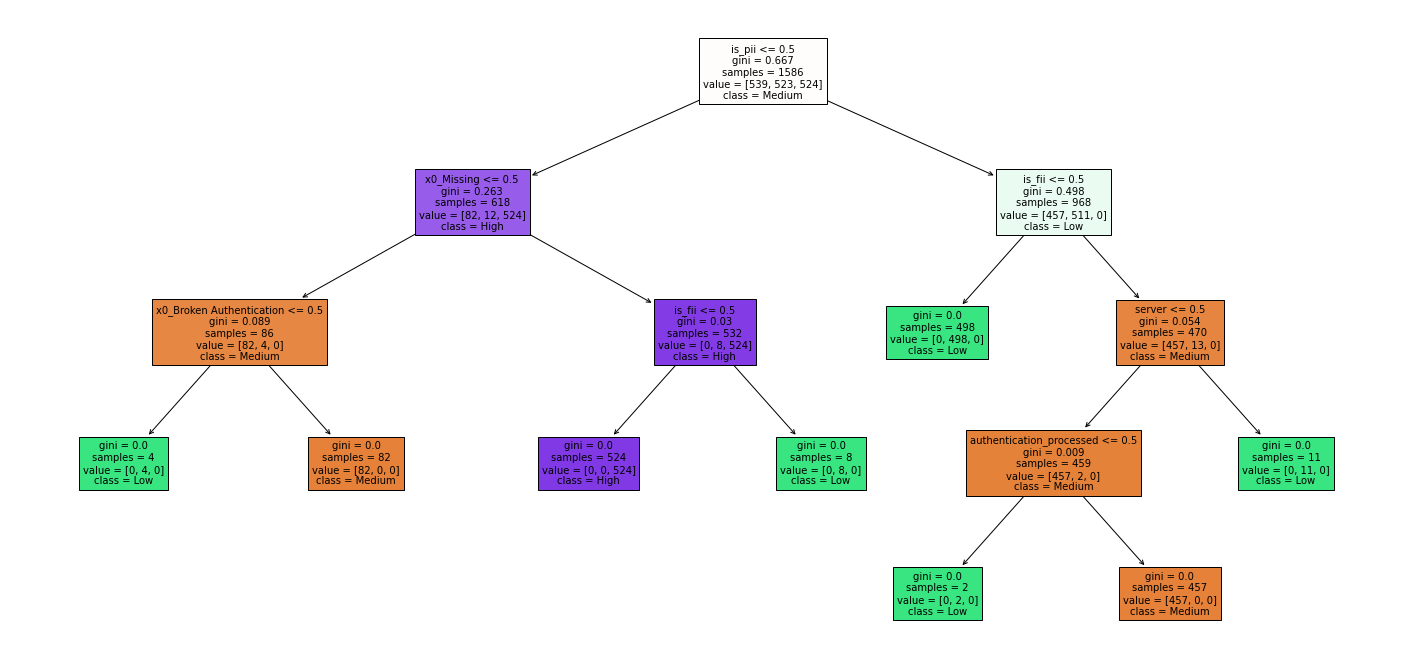

In [52]:
# Visualise the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize=(25,12))
fn = list(X_train)
cn = list(y_train)
tree.plot_tree(clf, 
              feature_names = fn,
              class_names = cn,
              fontsize=10,
              filled=True)
fig.savefig('trial.png')

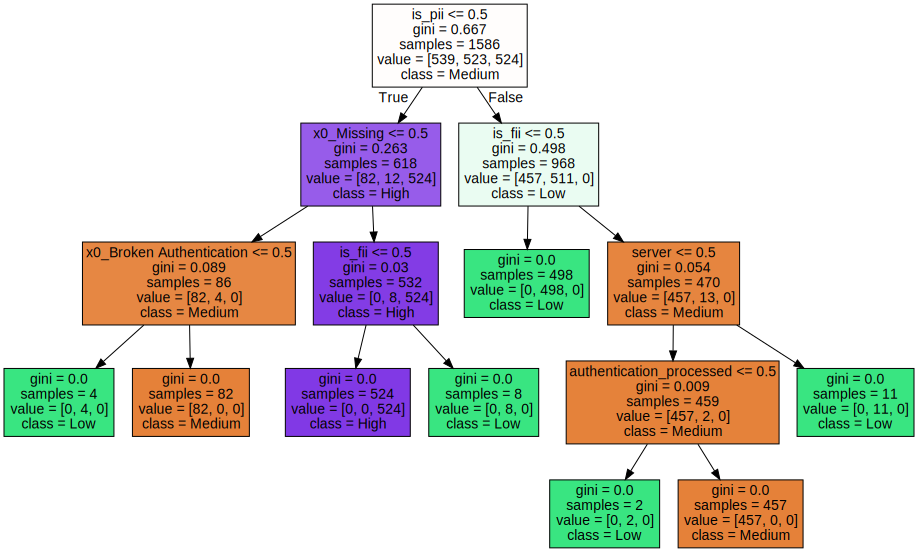

In [53]:
# Alternative visualisation
visualise_tree = tree.export_graphviz(clf, out_file=None,
                                      feature_names = fn,
                                      class_names = cn,
                                     filled=True)
graph = graphviz.Source(visualise_tree)
graph

# See here for more [https://scikit-learn.org/stable/modules/tree.html]


In [54]:
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9974811083123426


### Various hyperparameters to attempt

In [55]:
# max depth
clf_maxdepth = DecisionTreeClassifier(random_state=37, max_depth=5)
clf_maxdepth = clf_maxdepth.fit(X_train,y_train)
y_pred = clf_maxdepth.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9974811083123426


In [56]:
# max_leaf_nodes
clf_maxleafnode = DecisionTreeClassifier(random_state=37, max_leaf_nodes=5)
clf_maxleafnode = clf_maxleafnode.fit(X_train,y_train)
y_pred = clf_maxleafnode.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9848866498740554


## 2. Random Forest

### Basic Approach

In [57]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [58]:
scoring_metric = ["accuracy", "f1_weighted"]
results = {}

In [59]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_clf = RandomForestClassifier(n_estimators=100, random_state=37, n_jobs=-1) # n_estimators = no. of trees in the forest
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=37)

In [60]:
results["Random forests"] = mean_std_cross_val_scores(
    rf_clf, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1_weighted,train_f1_weighted
Random forests,0.833 (+/- 1.704),0.018 (+/- 0.005),0.997 (+/- 0.002),1.000 (+/- 0.000),0.997 (+/- 0.002),1.000 (+/- 0.000)


In [61]:
# rf_clf(X_test)

In [62]:
# print("Accuracy:", metrics.accuracy_score(y_test, y_pred_rf_clf))

In [63]:
# feature importance
# feature_imp = pd.Series(rf_clf.feature_importances_, 
                        # index = X_train.feature_names).sort_values(ascending = False)
# feature_imp

### Various hyperparameters to attempt

In [64]:
# random_grid = {'bootstrap': [True, False],
#                'max_depth': [2, 4, 6, 8, 10, 12, None],
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [130, 180, 230]}

In [65]:
# scoring_metric = ["accuracy"]
# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=37, 
#                                n_jobs = -1,
#                                scoring = scoring_metric,
#                                return_train_score=True)

In [66]:
# rf_random.fit(X_train, y_train)

In [67]:
# cv_results = rf_random.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

In [68]:
# find best params
# best_params = rf_random.best_params_
# best_params

In [69]:
# best score
# rf_random.best_score_

In [70]:
# df_rf_random = pd.DataFrame(rf_random.cv_results_)
# df_rf_random

## 3. All the boosts

### Reference:
https://pages.github.ubc.ca/mds-2021-22/DSCI_573_feat-model-select_students/lectures/05_ensembles.html

In [71]:
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=37),
    "XGBoost": XGBClassifier(random_state=37, eval_metric='logloss', verbosity=0),
    # "LightGBM": LGBMClassifier(random_state=37),
    "Decision Tree": DecisionTreeClassifier(random_state=37),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=37)
}

In [72]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [73]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


In [74]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [75]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sonchau/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sonchau/miniconda3/envs/capstone/lib/python3.9/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/Users/sonchau/miniconda3/envs/capstone/lib/python3.9/site-packages/xgboost/sklearn.py", line 1357, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['High' 'Low' 'Medium']


In [ ]:
pd.DataFrame(results).T

In [ ]:
# CatBoost
model = CatBoostClassifier(verbose=0, random_state=37)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f"Model: CatBoost")
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"F1 score: {metrics.f1_score(y_test, predictions, average='macro')}")
print(f"Recall: {metrics.recall_score(y_test, predictions, average='macro')}")

In [ ]:

print(
    classification_report(
        y_test, predictions, target_names=["High", "Low", "Medium"]
    )
)

In [ ]:
# Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=37)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f"Model: Random Forest")
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"F1 score: {metrics.f1_score(y_test, predictions, average='macro')}")
print(f"Recall: {metrics.recall_score(y_test, predictions, average='macro')}")

In [ ]:
print(
    classification_report(
        y_test, predictions, target_names=["High", "Low", "Medium"]
    )
)

In [ ]:
# Decision Tree
model = DecisionTreeClassifier(random_state=37)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f"Model: Decision Tree")
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"F1 score: {metrics.f1_score(y_test, predictions, average='macro')}")
print(f"Recall: {metrics.recall_score(y_test, predictions, average='macro')}")

In [ ]:
print(
    classification_report(
        y_test, predictions, target_names=["High", "Low", "Medium"]
    )
)